# ResistanceGA
## Genetic Algorithm and Simulated Data

This code uses the ResistanceGA package from https://github.com/wpeterman/ResistanceGA/tree/julia_dev. The project is widely used for problems focusing on using genetic algorithms for resistance surface calculations. I installed from a local clone of the package because the main branch had some bugs that have been resolved in the more recent julia_dev branch. I cloned this branch as of 2:30pm on 4/26/2019. Peterman has made updates since then, but I have not installed a more recent version.

In [1]:
# install updates to local ResistanceGA using command: 
# devtools::install(pkg = "../ResistanceGA")

To set up to use the code, we need to include the ResistanceGA library and give it the director to run the code. It will put all the results in a directory called Write, created within base_dir.

We will be using the rbenchmark library to time the algorithm.

In [2]:
# setup
library(ResistanceGA)
library(rbenchmark)

write.dir <- "./Results/"

data(resistance_surfaces)
data(samples)
write.table(samples,file=paste0(write.dir,"samples.txt"),sep="\t",col.names=F,row.names=F)

# Create a spatial points object for plotting
sample.locales <- SpatialPoints(samples[,c(2,3)])

Warning message:
"package 'ResistanceGA' was built under R version 3.5.3"Loading required package: raster
Warning message:
"package 'raster' was built under R version 3.5.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.5.3"Warning message:
"package 'rbenchmark' was built under R version 3.5.2"

## Plot the samples

In our stack, we will use categorical, continuous, and feature data. See graphs for each of these.

The categorical data might classify something like whether a certain area is city, wooded, etc.

The continuous might show the elevation of the terrain.

The feature data might be whether an area is river or not river.

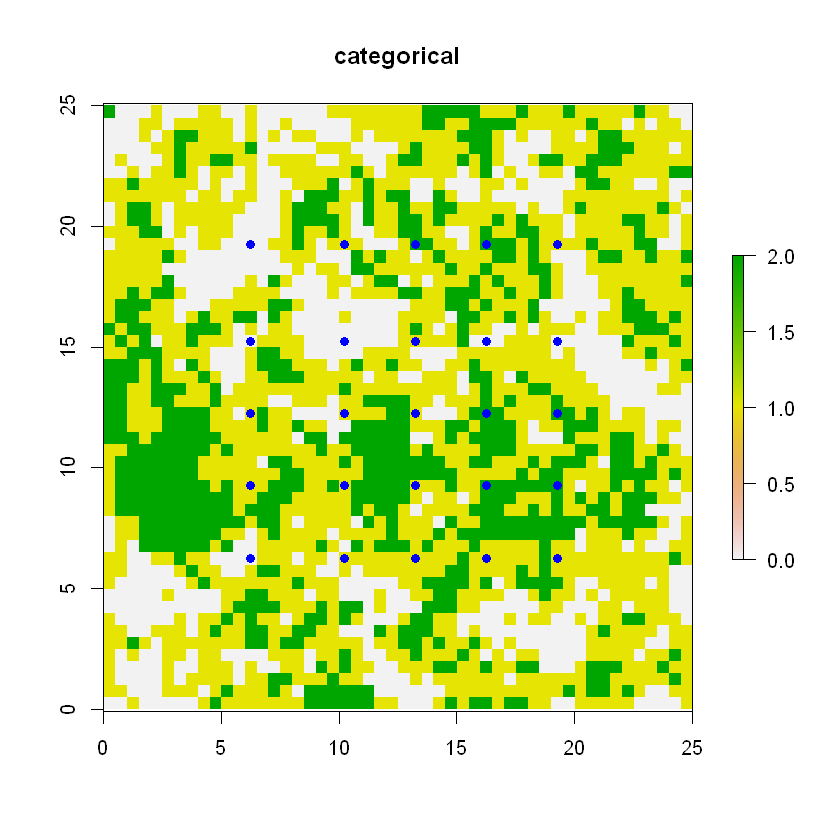

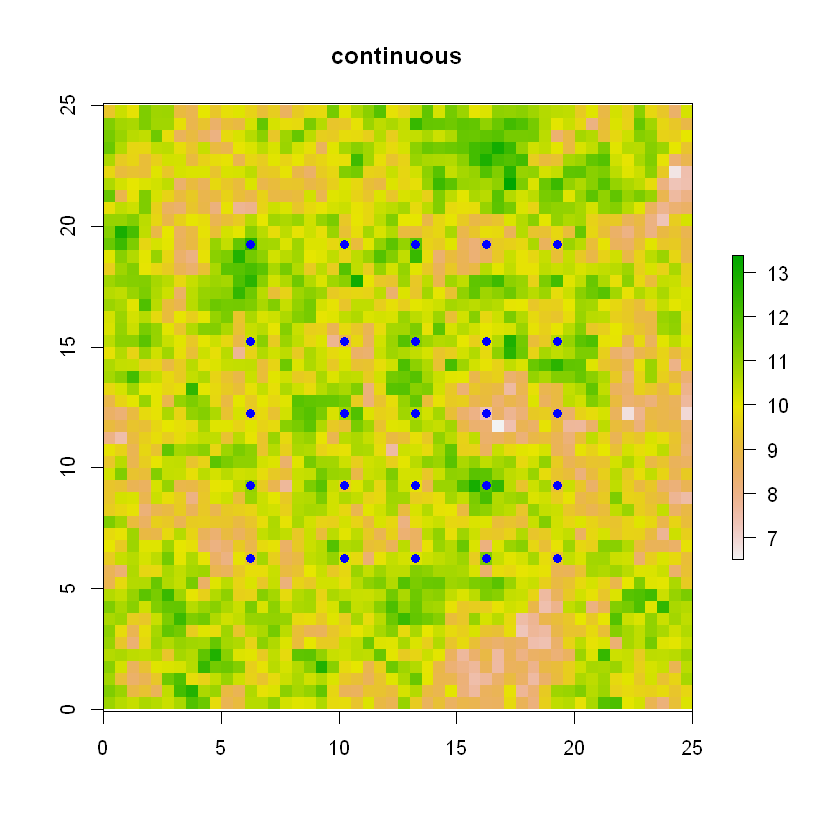

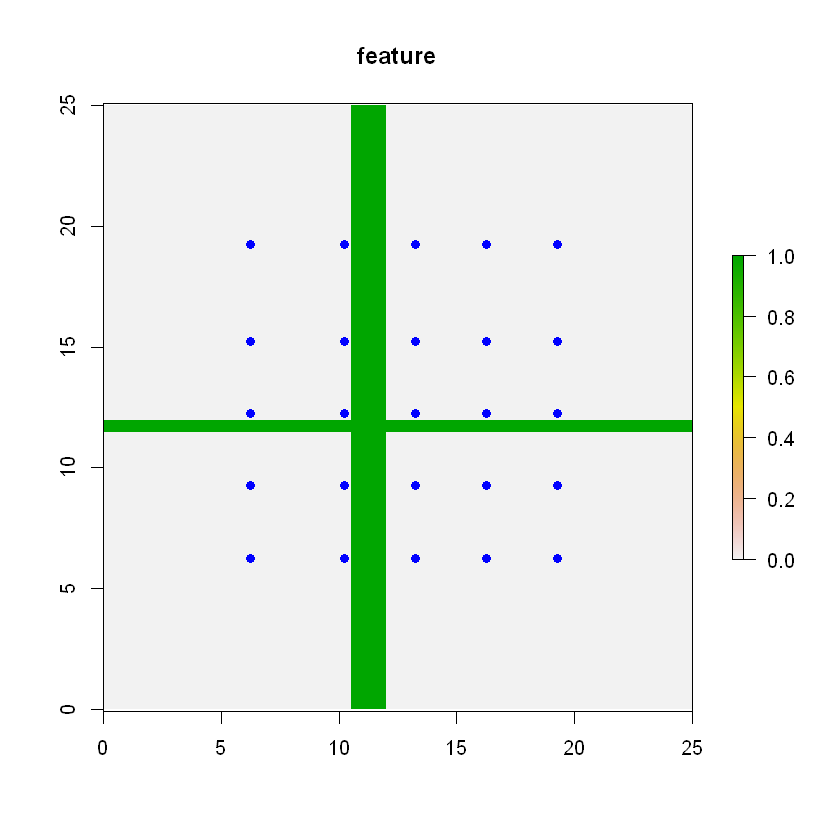

In [3]:
plot(resistance_surfaces[[1]],main = resistance_surfaces[[1]]@data@names)
plot(sample.locales, pch=16, col="blue", add=TRUE)

plot(resistance_surfaces[[2]],main = resistance_surfaces[[2]]@data@names)
plot(sample.locales, pch=16, col="blue", add=TRUE)

plot(resistance_surfaces[[3]],main = resistance_surfaces[[3]]@data@names)
plot(sample.locales, pch=16, col="blue", add=TRUE)

## ResistanceGA

Next, the genetic algorithms themselves come in.

First, we create the stack of the surfaces. Next, we input the parameters for the genetic algorithm. Next, we include the prep for the gdistance package. Next, there are a set of necessary parameters.

Next, it combines the surfaces from gdist into Resist, which are the true values.

It sets gdist.response to the cost distance. It sets gdist.inputs into the necessary input for optimizing on pairwise cost distances, as we plan to do with the genetic alogorithm.

The MS_optim() function runs the genetic algorithm itself. The number of iterations it uses can vary, as it stops when it stops seeing improvement.

In [4]:
r.stack <- stack(resistance_surfaces$categorical,  ###RasterStack - raw raster data
                 resistance_surfaces$continuous,
                 resistance_surfaces$feature)

PARM <- c(1, 250, 75, 1, 3.5, 150, 1, 350)

benchmark("GA.prep" = {
            GA.inputs <- GA.prep(ASCII.dir = r.stack,   ###Input parameters for Genetic Algorithm
                                 Results.dir = write.dir,
                                 method = "LL",
                                 max.cat = 500,
                                 max.cont = 500,
                                 seed = 555,
                                 parallel = 4)
          },
          "gdist.prep [1]" = {
            gdist.inputs <- gdist.prep(length(sample.locales),   ###Input parameters for gdistance package (dependency)
                                       samples = sample.locales,
                                       method = 'commuteDistance')
          },
          "Combine_Surfaces" = {
            Resist <- Combine_Surfaces(PARM = PARM,
                                       gdist.inputs = gdist.inputs,
                                       GA.inputs = GA.inputs,
                                       out = NULL,
                                       rescale = TRUE)          },
          "Run_gdistance" = {
            gdist.response <- Run_gdistance(gdist.inputs = gdist.inputs,
                                            r = Resist)
          },
          "gdist.prep [2]" = {
            gdist.inputs <- gdist.prep(n.Pops = length(sample.locales),
                                       samples = sample.locales,
                                       response = as.vector(gdist.response),
                                       method = 'commuteDistance')            
          },
          "MS_optim" = {
            Multi.Surface_optim <- MS_optim(gdist.inputs = gdist.inputs,
                                            GA.inputs = GA.inputs)
          },
          replications = 0,
          columns = c("test", "replications", "elapsed", "user.self", "sys.self"))

GA | iter = 1 | Mean = -350.40025 | Best =   27.28509
GA | iter = 2 | Mean = -29173.14265 | Best =     27.28509
GA | iter = 3 | Mean = -39129.1755 | Best =    261.4719
GA | iter = 4 | Mean = -29148.3849 | Best =    261.4719
GA | iter = 5 | Mean = -29118.2654 | Best =    261.4719
GA | iter = 6 | Mean = -25111.5670 | Best =    276.9272
GA | iter = 7 | Mean = -23081.9319 | Best =    347.2193
GA | iter = 8 | Mean = -27059.2170 | Best =    347.2193
GA | iter = 9 | Mean = -28048.4202 | Best =    347.2193
GA | iter = 10 | Mean = -19075.4279 | Best =    347.2193
GA | iter = 11 | Mean = -17060.488 | Best =    358.283
GA | iter = 12 | Mean = -18058.2809 | Best =    363.9235
GA | iter = 13 | Mean = -13047.7388 | Best =    377.3908
GA | iter = 14 | Mean = -13045.8036 | Best =    377.3908
GA | iter = 15 | Mean = -12048.4584 | Best =    489.8239
GA | iter = 16 | Mean = -12046.2643 | Best =    489.8239
GA | iter = 17 | Mean = -8028.6370 | Best =   489.8239
GA | iter = 18 | Mean = -2032.8051 | Best = 

,test,replications,elapsed,user.self,sys.self
3,Combine_Surfaces,0,0,0,0
1,GA.prep,0,0,0,0
2,gdist.prep [1],0,0,0,0
5,gdist.prep [2],0,0,0,0
6,MS_optim,0,0,0,0
4,Run_gdistance,0,0,0,0


## Graphing the results

Finally, we are able to graph and see the results. Because it is simulated data, we have both the true values and the values based on our optimization. As you can see, the optimization results match the true values.

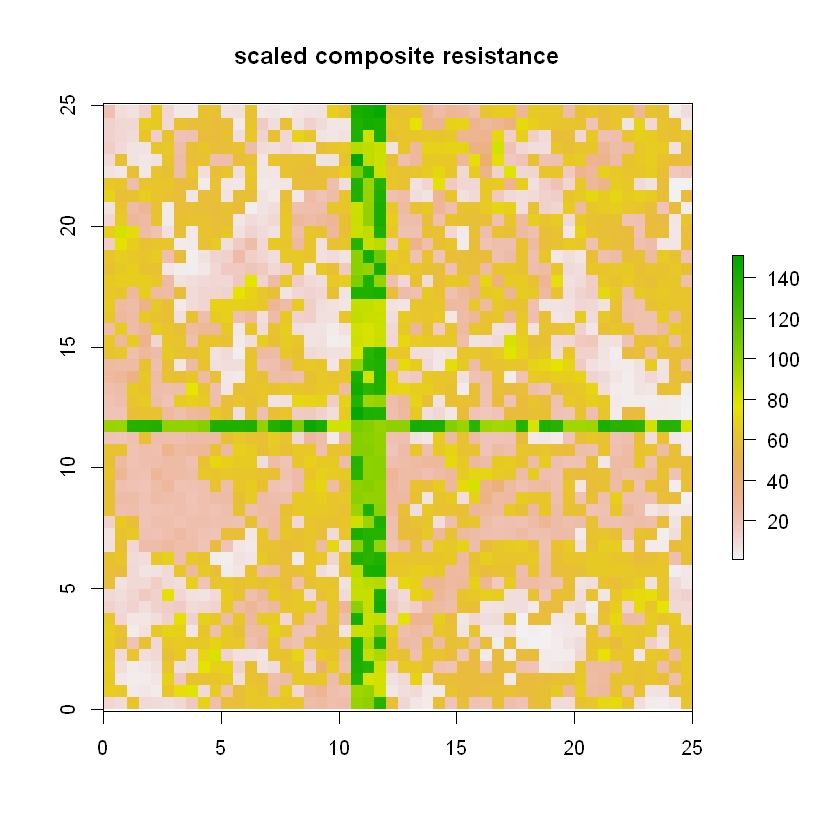

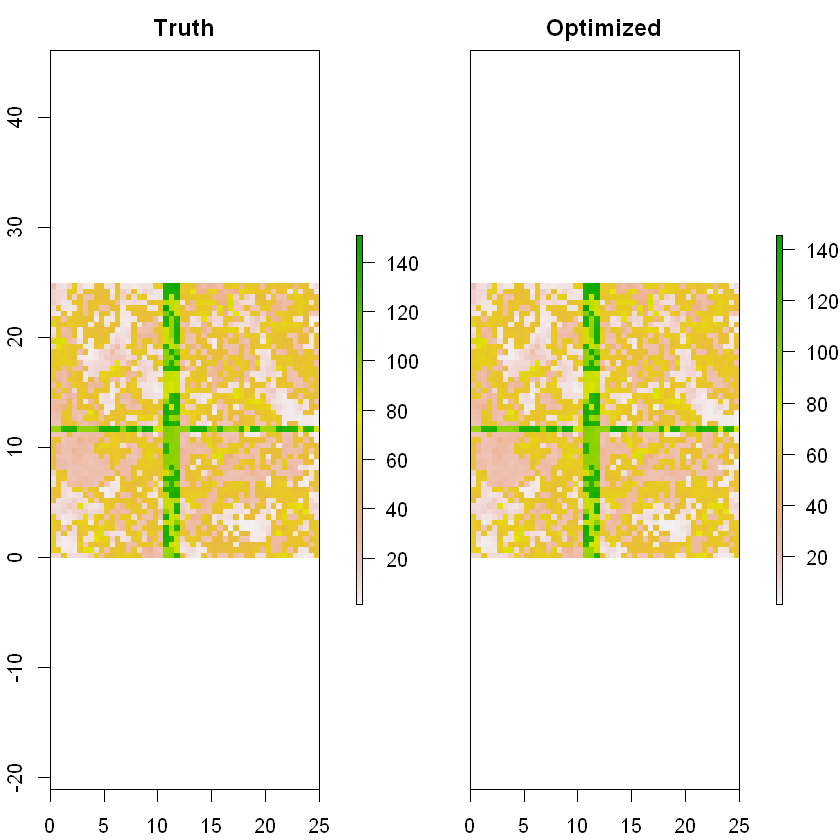

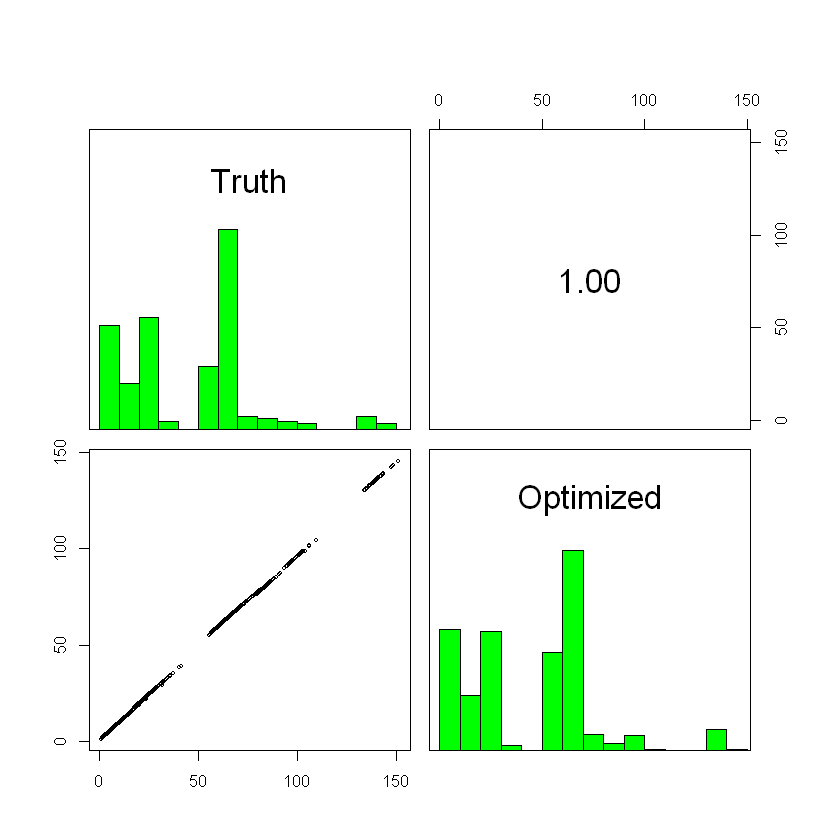

In [5]:
# View combined surface
plot(Resist, main = "scaled composite resistance")

# Make combined, optimized resistance surface.
optim.resist <- Combine_Surfaces(PARM = Multi.Surface_optim$GA.summary@solution,
                                 gdist.inputs = gdist.inputs,
                                 GA.inputs = GA.inputs,
                                 rescale = TRUE)
ms.stack <- stack(Resist, optim.resist)
names(ms.stack) <- c("Truth", "Optimized")
plot(ms.stack)

# Correlation between the two surfaces
pairs(ms.stack)

## Note on Timing

The timing is not currently working. I am planning to simplify it to use the sys.time().

The Genetic Algorithm is timed. However, it is important to keep in mind that different runs take signficantly different amounts of time to run, even with the same data and same seed. According to Professor Miller, the seeding doesn't work for the package. Finding a more accurate expression of the time is an issue that still needs to be addressed.